## In this tutorial we create a CNN and dataloaders, and train / prune the model.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch" # Needs to be set, some pruning layers as well as the quantizers are Keras
import keras
keras.config.set_backend("torch")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
keras.backend.set_image_data_format("channels_first")

In [2]:
try:
    os.chdir("/home/das214/PQuant/mdmm_dev/src")
except:
    pass

for f in os.listdir(os.getcwd()):
    print(f)

resnet_mdmm_unstr_paca_pruned.pth
resnet_mdmm_unstr_pruned.pth
resnet_paca_pruned.pth
pquant
data
smartpixels


In [3]:
SAVE_PATH = 'resnet_mdmm_unstr_pruned.pth'
# torch.save(model_copy.state_dict(), SAVE_PATH)

model = torchvision.models.resnet18()
model.load_state_dict(torch.load(SAVE_PATH))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/tmp/ipykernel_447090/842026278.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(new_ytick)


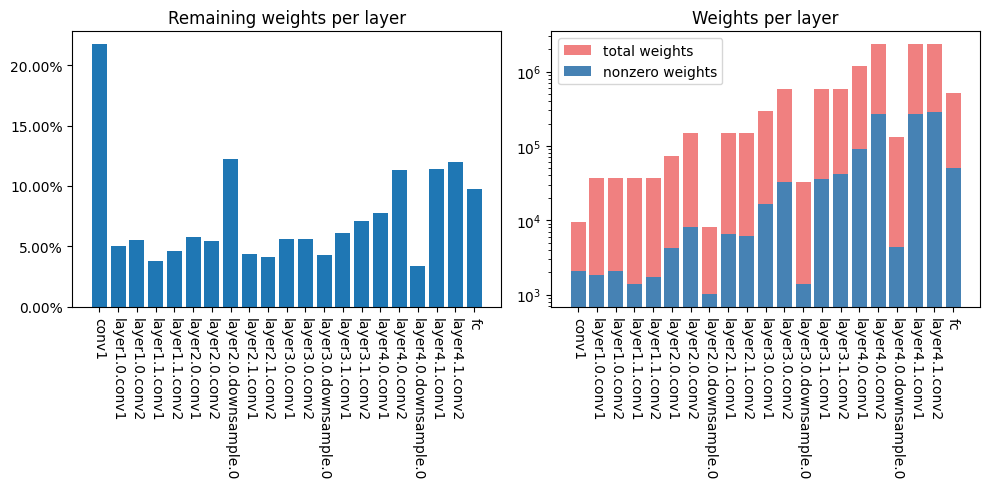

In [4]:
# Plot remaining weights
import numpy as np
import matplotlib.pyplot as plt

names = []
remaining = []
total_w = []
nonzeros = []
for n, m in model.named_modules():
    if isinstance(m, (torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Linear)):
        names.append(n)
        nonzero = np.count_nonzero(m.weight.detach().cpu())
        remaining_pct = nonzero / m.weight.numel()
        remaining.append(remaining_pct)
        total_w.append(m.weight.numel())
        nonzeros.append(nonzero)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(len(names)), remaining)
ax[0].set_xticks(range(len(names)))
ax[0].set_xticklabels(names)
ax[0].tick_params(axis='x', labelrotation=270)
new_ytick = []
for i in ax[0].get_yticklabels():
    ytick = f"{float(i.get_text()) * 100:.2f}%"
    new_ytick.append(ytick)
ax[0].set_yticklabels(new_ytick)
ax[0].title.set_text("Remaining weights per layer")

ax[1].bar(range(len(nonzeros)), total_w, color="lightcoral", label="total weights")
ax[1].bar(range(len(nonzeros)), nonzeros, color="steelblue", label="nonzero weights")
ax[1].set_xticks(range(len(names)))
ax[1].set_xticklabels(names)
ax[1].tick_params(axis='x', labelrotation=270)
ax[1].title.set_text("Weights per layer")
ax[1].legend()
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

In [5]:
import keras
from keras import ops
import numpy as np
import torch # Keep for isinstance check


In [6]:
from functools import lru_cache

_AX = {"H": 0,   # kernel height  (kH)
       "W": 1,   # kernel width   (kW)
       "I": 2,   # input  channels (C_in)
       "O": 3}   # output channels (C_out)

def _layout_to_axes(layout: str):
    if len(layout) != 4 or set(layout) != set("HWIO"):
        raise ValueError("layout must be a permutation of 'HWIO'")
    return tuple(_AX[ch] for ch in layout)

@lru_cache(maxsize=None)
def _perm(src: str, dst: str):
    """
    Constant-time (cached) permutation tuple that reorders *src*→*dst*.
    """
    s = _layout_to_axes(src)
    d = _layout_to_axes(dst)
    return tuple(s.index(ax) for ax in d) 


def convert_conv_layout(w, src: str, dst: str = "HWIO"):
    if src == dst:
        return w                             
    perm = _perm(src, dst)                     # Python‑level, cached
    if perm == (0, 1, 2, 3):                   # identity permutation
        return w
    return ops.transpose(w, perm)

In [7]:
def _get_kernels_and_patterns(w, src="OIHW", epsilon=1e-5):
    # src:
    #   PyTorch: (out, in, kH, kW): OIHW
    #   Keras  : (kH, kW, in, out): HWIO
    w_permuted = convert_conv_layout(w, src="OIHW", dst="OIHW")
    C_out, C_in, kH, kW = ops.shape(w_permuted)
    kernels = ops.reshape(w_permuted, (C_out * C_in, -1))
    all_patterns = ops.cast(ops.greater_equal(ops.abs(kernels), epsilon), dtype=w.dtype)

    return kernels, all_patterns, (C_out, C_in, kH, kW)

def _get_unique_patterns_with_counts(all_patterns):
    """Returns the unique patterns and their counts."""
    np_patterns = ops.convert_to_numpy(all_patterns)
    uniq_np, counts_np = np.unique(np_patterns, axis=0, return_counts=True)

    unique_patterns = ops.convert_to_tensor(uniq_np, dtype=all_patterns.dtype)
    counts          = ops.convert_to_tensor(counts_np.astype("int32"), dtype="int32")
    return unique_patterns, counts

def _select_dominant_patterns(all_patterns, unique_patterns, counts, alpha, beta, dtype=None):
    """Selects the most frequent patterns based on alpha and beta."""
    if not dtype:
        raise ValueError("dtype must be provided")
    if ops.shape(unique_patterns)[0] == 0:
        return unique_patterns

    # ---------------- PDF ---------------------------------------------------
    total = ops.cast(ops.shape(all_patterns)[0], dtype)
    pdf   = ops.cast(counts, dtype) / total                     # (U,)

    # ---------------- sort by descending freq (single argsort) -------------
    order   = ops.argsort(-pdf)                                 # (U,)
    pdf_s   = ops.take(pdf, order)
    pat_s   = ops.take(unique_patterns, order, axis=0)

    # ---------------- CDF & first index >= beta -------------------------------
    cdf     = ops.cumsum(pdf_s)                                 # (U,)
    mask    = cdf >= beta                                       # (U,) bool
    has_hit = ops.any(mask)                                     # scalar bool

    # idx_first_true = argmax(mask)  (undefined if no True, but guarded)
    idx      = ops.argmax(mask)                                 # scalar int64
    n_beta   = ops.cast(idx + 1, counts.dtype)                  # scalar int32
    n_total  = ops.cast(ops.shape(cdf)[0], counts.dtype)

    # choose beta‑cut or full length
    keep_beta = ops.where(has_hit, n_beta, n_total)             # scalar int32
    keep      = ops.minimum(keep_beta, ops.cast(alpha, counts.dtype))

    return pat_s[:keep]                                         # (keep, K)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from keras import ops


def plot_pattern_distributions(counts, dominant_patterns, layer_name = "conv1", log_scale1 = False, log_scale2 = False):
    counts_np  = ops.convert_to_numpy(counts)                # (U,)
    order      = np.argsort(-counts_np)                      # descending freq
    sorted_cnt = counts_np[order]

    n_keep     = dominant_patterns.shape[0]                  # M  <= alpha

    fig1, ax1 = plt.subplots(figsize=(8, 5))
    ax1.bar(np.arange(sorted_cnt.size), sorted_cnt, linewidth=0)
    if log_scale1: ax1.set_yscale("log")
    ax1.set_xlabel("Pattern rank (frequency ↓)")
    ax1.set_ylabel("Count")
    ax1.set_title(f"Pattern distribution – {layer_name}")
    ax1.grid(axis="y", linestyle="--", alpha=0.6)
    ax1.axvline(n_keep - 0.5, color="red", linestyle="--",
                label=f"kept = {n_keep}")
    ax1.legend()
    fig1.tight_layout()

    dominant_cnt = sorted_cnt[:n_keep]

    fig2, ax2 = plt.subplots(figsize=(6, 4))
    ax2.bar(np.arange(n_keep), dominant_cnt, color="tab:orange", linewidth=0)
    if log_scale2: ax2.set_yscale("log")
    ax2.set_xlabel("Dominant pattern index (0‥M‑1)")
    ax2.set_ylabel("Count")
    ax2.set_title(f"Dominant patterns – {layer_name}")
    ax2.grid(axis="y", linestyle="--", alpha=0.6)
    fig2.tight_layout()

    plt.show()


In [9]:
import math
def plot_dominant_patterns(layer_name, all_patterns, counts, kH, kW, max_patterns_to_show=16):
    """
    Creates a grid visualization of the most dominant binary patterns.

    Returns: A matplotlib Figure object for saving.
    """
    patterns = all_patterns.cpu().numpy()
    kernel_h, kernel_w = kH, kW
    num_to_show = min(len(patterns), max_patterns_to_show)

    cols = math.ceil(math.sqrt(num_to_show))
    rows = math.ceil(num_to_show / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2.2))
    axes = np.array(axes).flatten()

    fig.suptitle(f"Dominant Patterns for Layer: {layer_name}", fontsize=16)

    for i in range(num_to_show):
        pattern_2d = patterns[i].reshape(kernel_h, kernel_w)
        axes[i].imshow(pattern_2d, cmap='binary', vmin=0, vmax=1, interpolation='nearest')
        axes[i].set_title(f"Pattern #{i+1}\n(Count: {counts[i]})")
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    # Hide unused subplots
    for j in range(num_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [10]:
def _pattern_distances(dominant_patterns, w):
    w_kernels, w_patterns, _ = _get_kernels_and_patterns(w, src = "OIHW")
    w_kernels_exp = ops.expand_dims(w_kernels, 1)
    w_patterns_exp = ops.expand_dims(w_patterns, 1)
    dom_patterns_exp = ops.expand_dims(dominant_patterns, 0)


    projected_kernels = w_kernels_exp * dom_patterns_exp
    k_dot_projected = ops.sum(w_kernels_exp * projected_kernels, axis=-1)
    norm_k = ops.norm(w_kernels_exp, axis=-1)
    norm_projected = ops.norm(projected_kernels, axis=-1)
    cosine_similarity = k_dot_projected / (norm_k * norm_projected + keras.backend.epsilon())
    distances = 1.0 - cosine_similarity

    return w_kernels, distances

def project_kernels_to_dom_patterns(weight):
    if len(ops.shape(weight)) != 4:
        return ops.ones_like(weight)

    kernels, all_patterns, (C_out, C_in, kH, kW) = _get_kernels_and_patterns(weight, src = "OIHW")
    unique_patterns, counts = _get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = _select_dominant_patterns(all_patterns, unique_patterns, counts, 
                                                            alpha = 16, beta = 0.75, dtype=weight.dtype)
    kernels, _, (C_out, C_in, kH, kW) = _get_kernels_and_patterns(weight)
    _, dist = _pattern_distances(dominant_patterns, weight)                 # (C_out*C_in, n_patterns)
    closest = ops.argmin(dist, axis=1)                   # (C_out*C_in,)
    pat_support = ops.take(dominant_patterns, closest, axis=0)

In [26]:
SAVE_PATH = 'resnet_mdmm_unstr_pruned.pth'

model = torchvision.models.resnet18()
model.load_state_dict(torch.load(SAVE_PATH))


<All keys matched successfully>

In [31]:
for name, module in model.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue
    
    kernels, all_patterns, (C_out, C_in, kH, kW) =_get_kernels_and_patterns(module.weight)
    unique_patterns, counts = _get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = _select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.99, dtype=module.weight.dtype)

    print(name, len(dominant_patterns))
    print(dominant_patterns.shape)
    print()
    # plot_pattern_distributions(counts, dominant_patterns, layer_name = name, log_scale1 = False, log_scale2 = True)
    # try: plot_dominant_patterns(name, all_patterns, counts, kH, kW, max_patterns_to_show=16)
    # except: pass
    
    # break

conv1 16
torch.Size([16, 49])

layer1.0.conv1 16
torch.Size([16, 9])

layer1.0.conv2 16
torch.Size([16, 9])

layer1.1.conv1 16
torch.Size([16, 9])

layer1.1.conv2 16
torch.Size([16, 9])

layer2.0.conv1 16
torch.Size([16, 9])

layer2.0.conv2 16
torch.Size([16, 9])

layer2.0.downsample.0 2
torch.Size([2, 1])

layer2.1.conv1 16
torch.Size([16, 9])

layer2.1.conv2 16
torch.Size([16, 9])

layer3.0.conv1 16
torch.Size([16, 9])

layer3.0.conv2 16
torch.Size([16, 9])

layer3.0.downsample.0 2
torch.Size([2, 1])

layer3.1.conv1 16
torch.Size([16, 9])

layer3.1.conv2 16
torch.Size([16, 9])

layer4.0.conv1 16
torch.Size([16, 9])

layer4.0.conv2 16
torch.Size([16, 9])

layer4.0.downsample.0 2
torch.Size([2, 1])

layer4.1.conv1 16
torch.Size([16, 9])

layer4.1.conv2 16
torch.Size([16, 9])



In [25]:
dominant_patterns.shape

torch.Size([16, 49])

In [13]:
weight = module.weight
_, distances = _pattern_distances(dominant_patterns, weight) # Shape: (C_out*C_in, num_dominant)
closest_pattern_indices = ops.argmin(distances, axis=1) # Shape: (C_out*C_in,)
projection_mask_flat = ops.take(dominant_patterns, closest_pattern_indices, axis=0)
projection_mask = ops.reshape(projection_mask_flat, (C_out, C_in, kH, kW))

projected_weight = weight.cpu() * projection_mask.cpu()

In [14]:
projected_weight[1].reshape(7, 7, 3)[:, :, 0]

tensor([[-0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.1903],
        [-0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2420],
        [-0.0622, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000]],
       grad_fn=<SelectBackward0>)

In [15]:
SAVE_PATH = 'resnet_mdmm_unstr_paca_pruned.pth'

model_paca = torchvision.models.resnet18()
model_paca.load_state_dict(torch.load(SAVE_PATH))

<All keys matched successfully>

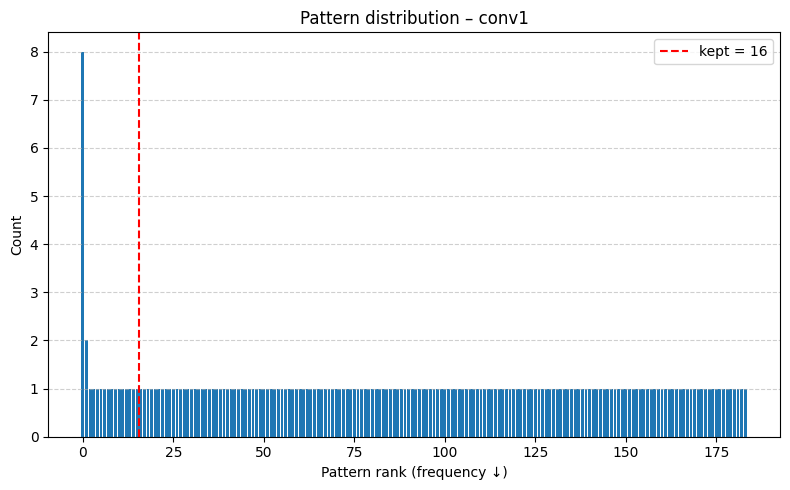

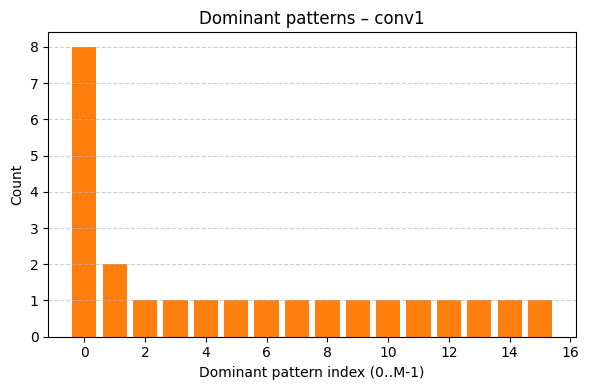

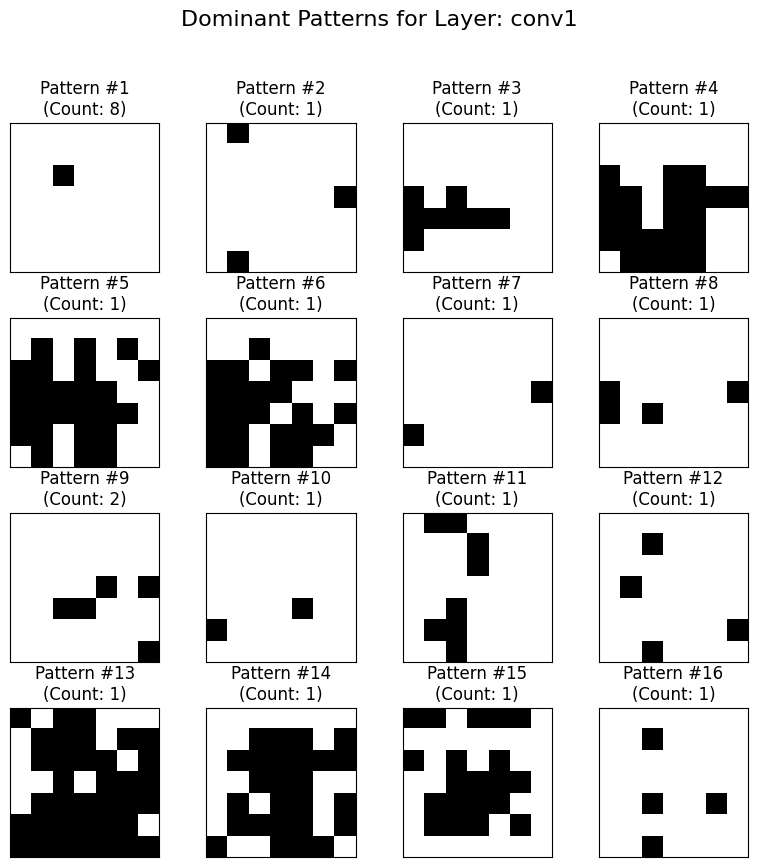

In [16]:
for name, module in model.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue
    
    kernels, all_patterns, (C_out, C_in, kH, kW) =_get_kernels_and_patterns(module.weight)
    unique_patterns, counts = _get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = _select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.75, dtype=module.weight.dtype)

    plot_pattern_distributions(counts, dominant_patterns, layer_name = name, log_scale1 = False, log_scale2 = False)
    try: plot_dominant_patterns(name, all_patterns, counts, kH, kW, max_patterns_to_show=16)
    except: pass
    
    break

In [17]:
dominant_patterns.shape

torch.Size([16, 49])

In [18]:
print(counts)
print(len(unique_patterns))

tensor([8, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0',
       dtype=torch.int32)
184


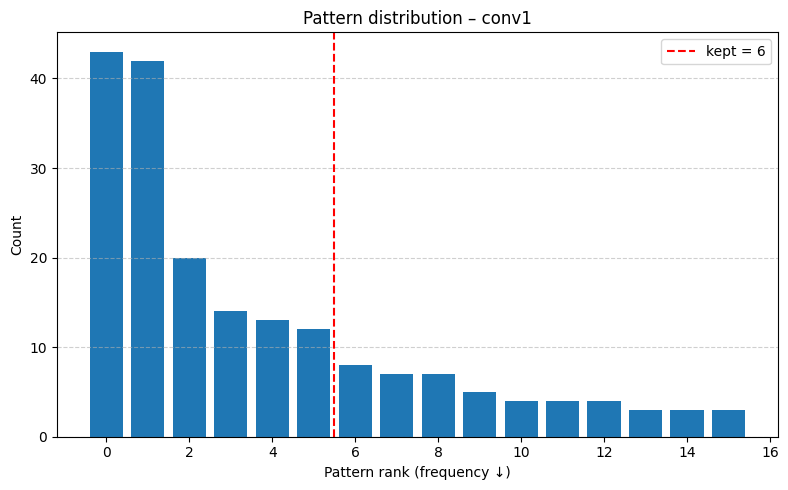

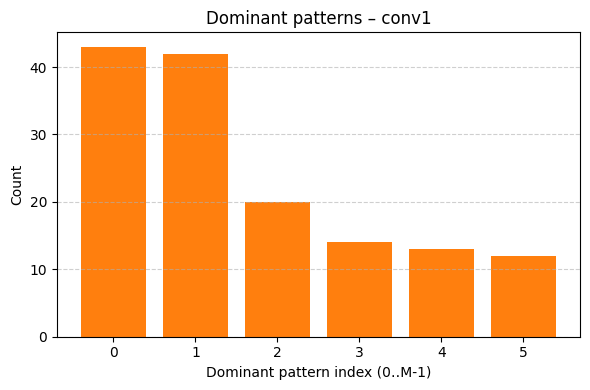

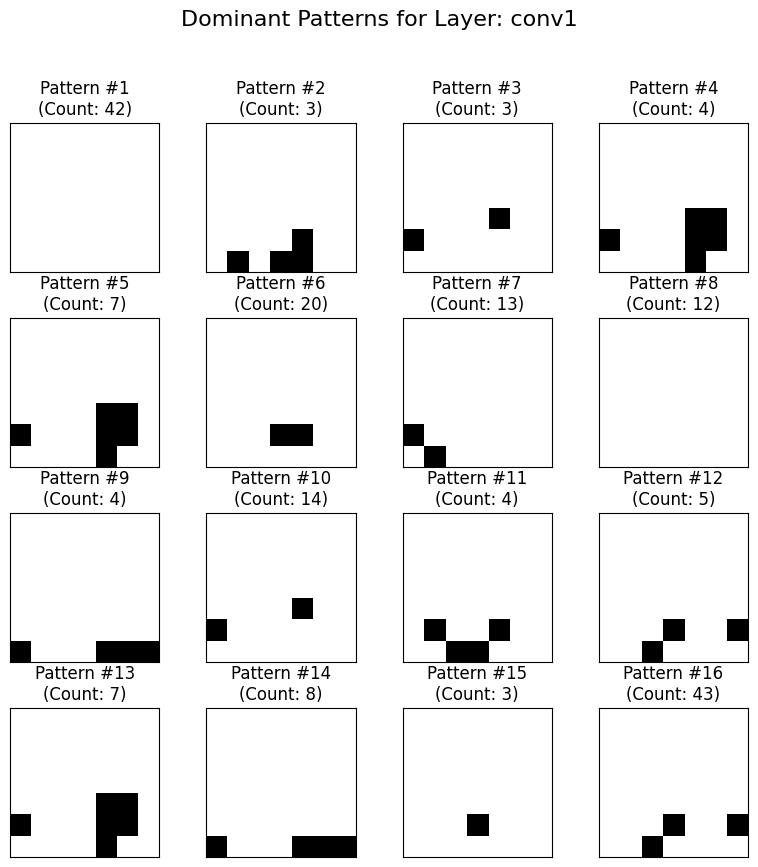

In [19]:
for name, module in model.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue
    
    kernels, all_patterns, (C_out, C_in, kH, kW) =_get_kernels_and_patterns(module.weight)
    unique_patterns, counts = _get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = _select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.75, dtype=module.weight.dtype)

    _, distances = _pattern_distances(dominant_patterns, weight) # Shape: (C_out*C_in, num_dominant)
    closest_pattern_indices = ops.argmin(distances, axis=1) # Shape: (C_out*C_in,)
    projection_mask_flat = ops.take(dominant_patterns, closest_pattern_indices, axis=0)
    projection_mask = ops.reshape(projection_mask_flat, (C_out, C_in, kH, kW))
    
    projected_weight = (weight.cpu() + 1.0e-5)* projection_mask.cpu()

    weight = projected_weight
    kernels, all_patterns, (C_out, C_in, kH, kW) =_get_kernels_and_patterns(weight)
    unique_patterns, counts = _get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = _select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.75, dtype=module.weight.dtype)

    plot_pattern_distributions(counts, dominant_patterns, layer_name = name, log_scale1 = False, log_scale2 = False)
    try: plot_dominant_patterns(name, all_patterns, counts, kH, kW, max_patterns_to_show=16)
    except: pass
    
    break

In [20]:
weight = module.weight
_, distances = _pattern_distances(dominant_patterns, weight) # Shape: (C_out*C_in, num_dominant)
closest_pattern_indices = ops.argmin(distances, axis=1) # Shape: (C_out*C_in,)
projection_mask_flat = ops.take(dominant_patterns, closest_pattern_indices, axis=0)
projection_mask = ops.reshape(projection_mask_flat, (C_out, C_in, kH, kW))

projected_weight = (weight.cpu() + 1.0e-5)* projection_mask.cpu()

In [21]:
weight = projected_weight
kernels, all_patterns, (C_out, C_in, kH, kW) =_get_kernels_and_patterns(weight)
unique_patterns, counts = _get_unique_patterns_with_counts(all_patterns)
dominant_patterns = _select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.75, dtype=module.weight.dtype)

print(counts)
print(len(unique_patterns))

tensor([ 30,  23,   4,  29, 106], device='cuda:0', dtype=torch.int32)
5


In [22]:
projected_weight[1]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         [-0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  3.8388e-01,
           1.0000e-05,  0.0000e+00],
         [-6.1947e-02,  0.0000e+00,  0.0000e+00, -0.0000e+00,  1.9032e-01,
           1.0000e-05,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,  7.2474e-02,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0